<font size="5">Tarea 1 Nicolás Garrido Parra</font>



Inicializamos las librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

Date                 object
Location              int64
Min_Temp            float64
Max_Temp            float64
Leakage             float64
Evaporation         float64
Electricity         float64
Parameter1_Dir       object
Parameter1_Speed    float64
Parameter2_9am       object
Parameter2_3pm       object
Parameter3_9am      float64
Parameter3_3pm      float64
Parameter4_9am      float64
Parameter4_3pm      float64
Parameter5_9am      float64
Parameter5_3pm      float64
Parameter6_9am      float64
Parameter6_3pm      float64
Parameter7_9am      float64
Parameter7_3pm      float64
Failure_today        object
dtype: object


,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,P1S,P39,P49,P53,P63,P79,Falla
count,112925.000000,112925.000000,112925.000000,112925.000000,71781.000000,66646.000000,112925.000000,112925.000000,112925.000000,112925.000000,74279.000000,112925.000000,112925.000000
mean,24.936418,12.664721,23.655670,2.377892,5.593073,7.727338,40.786611,15.179163,67.404162,1.015049,4.483111,17.462008,0.224654
std,14.453624,6.254135,6.982702,8.602968,4.208395,3.776340,13.321774,8.344304,18.911610,0.006958,2.715840,6.355045,0.417356
min,1.000000,-8.200000,2.600000,0.000000,0.000000,0.000000,7.000000,2.000000,0.000000,0.977100,0.000000,-3.100000,0.000000
25%,12.000000,8.100000,18.300000,0.000000,2.800000,5.000000,31.000000,9.000000,56.000000,1.010300,2.000000,12.700000,0.000000
50%,23.000000,12.400000,23.100000,0.000000,4.800000,8.600000,39.000000,13.000000,68.000000,1.015000,5.000000,17.100000,0.000000
75%,38.000000,17.200000,28.700000,0.800000,7.400000,10.700000,48.000000,20.000000,81.000000,1.019700,7.000000,22.000000,0.000000
max,49.000000,33.900000,48.100000,367.600000,82.400000,14.500000,135.000000,87.000000,100.000000,1.039600,9.000000,40.200000,1.000000


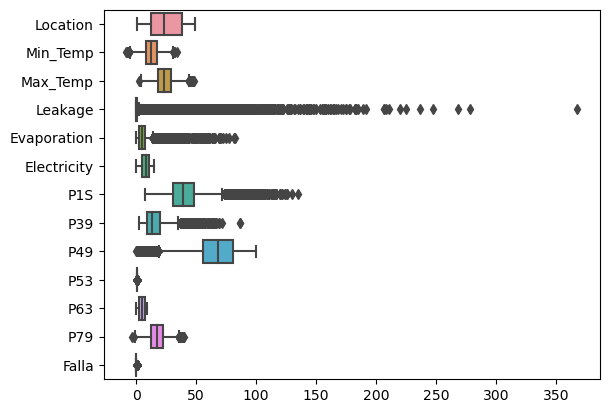

In [3]:
df = pd.read_csv('../../data/machine_failure_data.csv')
df2=df

df2 = df2.rename(columns={"Parameter1_Dir": "P1D", 
                        "Parameter1_Speed": "P1S","Parameter2_9am": "P29","Parameter2_3pm":"P23", 
                        "Parameter3_9am": "P39","Parameter3_3pm":"P33","Parameter4_9am": "P49",
                        "Parameter4_3pm":"P43","Parameter5_9am": "P59","Parameter5_3pm":"P53",
                        "Parameter6_9am": "P69","Parameter6_3pm":"P63","Parameter7_9am": "P79","Parameter7_3pm":"P73"})

print(df.dtypes)
##### dado que no podemos trabajar con Yes o No cambiamos esos valores por un parametro binario que será uno si ocurrió falla y cero si no lo hizo y eliminamos la columna Failure_today

df2["Falla"]=df2["Failure_today"].apply(lambda x:1 if x=="Yes" else 0)
df2=df2.drop(columns=["Failure_today"])
df2['Falla'] = df2['Falla'].astype(float)
df2["P59"]=df2["P59"]/1000
df2["P53"]=df2["P53"]/1000


##### eliminamos los valores null de las variables que no tienen tantos

df2 = df2.dropna(subset=['Min_Temp'])
df2 = df2.dropna(subset=['Max_Temp'])
df2 = df2.dropna(subset=['Leakage'])
df2 = df2.dropna(subset=['P1D'])
df2 = df2.dropna(subset=['P1S'])
df2 = df2.dropna(subset=['P29'])
df2 = df2.dropna(subset=['P23'])
df2 = df2.dropna(subset=['P39'])
df2 = df2.dropna(subset=['P33'])
df2 = df2.dropna(subset=['P49'])
df2 = df2.dropna(subset=['P43'])
df2 = df2.dropna(subset=['P59'])
df2 = df2.dropna(subset=['P53'])
df2 = df2.dropna(subset=['P79'])
df2 = df2.dropna(subset=['P73'])


##### cambiamos los nombres de algunos parametros por comodidad
df = df.rename(columns={"Parameter1_Dir": "P1D", 
                        "Parameter1_Speed": "P1S","Parameter2_9am": "P29","Parameter2_3pm":"P23", 
                        "Parameter3_9am": "P39","Parameter3_3pm":"P33","Parameter4_9am": "P49",
                        "Parameter4_3pm":"P43","Parameter5_9am": "P59","Parameter5_3pm":"P53",
                        "Parameter6_9am": "P69","Parameter6_3pm":"P63","Parameter7_9am": "P79","Parameter7_3pm":"P73"})

variables=["Location","Min_Temp","Max_Temp","Leakage","Evaporation","Electricity","P1D","P1S","P29","P23","P39","P33","P49","P43","P59","P53","P69","P63","P79","P73"]

##### dado que las distribuciones son similares entre los parametros que se tomaron en un horario u otro, vamos a usar uno el cual será el que tenga menos desviación estandar
df2=df2.drop(columns=["P69","P33","P43","P59","P73"])

sns.boxplot(data=df2, orient='h')   
df2.describe()

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Seleccionamos las variables independientes, para ello usaremos el criterio de realizar una matriz de correlación y ver cuales son las variables que se relacionan más con la variable dependiente, lo cual concluyó que filtraciones, P49, P1S, P39 y Min_Temp. Por otra parte, nuestra variable dependiente será la dicotómica "Falla". Luego de ejecutar OLS nos quedó que un 34.7% de la variabilidad de las fallas es explicada por nuestra variables independientes escogidas, las cuales son significativas de a cuerdo al criterio de p y su interpretación es : si la filtracion medida aumenta en una unidad, la probabilidad de falla aumentará, lo mismo para las otras variables con sus respectivos porcentajes.

                            OLS Regression Results                            
Dep. Variable:                  Falla   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     6608.
Date:               jue, 24 abr. 2025   Prob (F-statistic):               0.00
Time:                        17:32:55   Log-Likelihood:                -37457.
No. Observations:              112925   AIC:                         7.493e+04
Df Residuals:                  112919   BIC:                         7.498e+04
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5536      0.008    -67.320      0.0

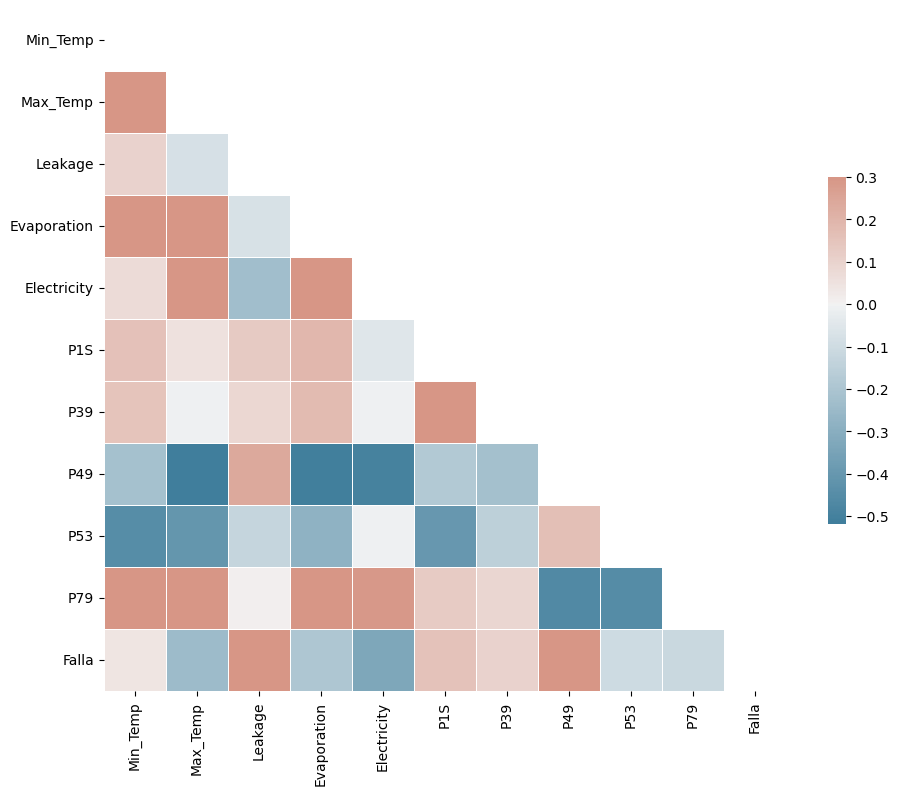

In [11]:
df3=df2
df3=df3.drop(columns=["Date","P29","P23","P1D","Location","P63"])
df3corre=df3.corr()

mask = np.triu(np.ones_like(df3corre, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df3corre, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
##### notamos que las fallas se correlacionan principalmente son Leackage, P49 y Min_Temp
y=df3["Falla"]
X=df3.drop(['Falla','Max_Temp','Evaporation',"Electricity","P53","P79"], axis=1)
X=X*100
X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

##### ols

3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Para este caso utilizaremos las mismas variables seleccionadas anteriormente (Falla para la dependiente y filtraciones, P1S, P39, P49, Min_Temp para las independientes), una vez realizada, obtuvimos que todas las variables eran significativas, dado que p< que 0.05. Sin embargo P1S y P49 tienen un valor de parámetro beta prácticamente despreciable, en el caso de las otras variables, las interpretamos de la siguiente manera 


Min_Temp: La disminución de una unidad de esta variable, provocará una disminución en la probabilidad de fallar

Leakage: El aumento de una unidad provoca un amumento de la probabilidad de fallar 

P39:   el aumento de una unidad provoca un aumento en la probabilidad de fallar  


In [43]:
model = sm.Probit(y, X)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

         Current function value: 0.000000
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:                  Falla   No. Observations:               112925
Model:                         Probit   Df Residuals:                   112919
Method:                           MLE   Df Model:                            5
Date:               mié, 23 abr. 2025   Pseudo R-squ.:                   1.000
Time:                        18:03:53   Log-Likelihood:            -0.00050611
converged:                      False   LL-Null:                       -60159.
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -96.8767      1.041    -93.081      0.000     -98.917     -94.837
Min_Temp      -0.0003   5.71e-05     -5.282      0.000      -0.00

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Podemos ver que esta vez la variable P39 no es significativa, mientras que las demás sí, por ende, excluimos P39, por otra parte. la interpretación de las demás variables es

Min_Temp: Por cada unidad de cambio la variable disminuye la probabilidad de fallar 
Leakage: por cada unidad de cambio se aumenta la probabilidad de falla
P1S: Por cada unidad que disminuya, la probabilidad de falla aumenta   
P49: Por cada unidad que aumente, la probabilidad de falla disminuye 

In [44]:

model = sm.Logit(y, X)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Falla   No. Observations:               112925
Model:                          Logit   Df Residuals:                   112919
Method:                           MLE   Df Model:                            5
Date:               mié, 23 abr. 2025   Pseudo R-squ.:                   1.000
Time:                        18:07:01   Log-Likelihood:            -3.1784e-06
converged:                      False   LL-Null:                       -60159.
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -375.8166      4.119    -91.240      0.000    -383.890    -367.744
Min_Temp      -0.0012      0.000     -3.763      0.000      -0.00

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

Yo opino que la diferencia de los resultados se debe a la especialidad de cada modelo, pues el Logit y Probit, al ser de funciones de acumulación de distribución, suelen ser mejores prediciendo variables binarias. Por ende, yo me quedo con Logit, pues no puedo asumir que los errores se distribuyen de manera normal. Finalmente las variables más robustas resultaron ser Leackage y Min_Temp, pues en todos los modelos fueron significativas y en general contaban con los valores más altos en su párametro, por lo que aportan el mayor porcentaje de explicación a predecir si existe falla o no.

6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

In [ ]:
yy=df3['Falla']
xx=df3[[""]]
poisson=sm.GLM(yy,xx,family=sm.families.Poisson()).fit()
print(poisson.summary())

#T
aux=((yy-poisson.mu)**2-poisson.mu)/poisson.mu
auxr=sm.OLS(aux,poisson.mu).fit()
print(auxr.summary())
#print(np.exp())

8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [ ]:
negbin=sm.GLM(yy,xx,family=sm.families.NegativeBinomial(alpha=0.786)).fit()
print(negbin.summary())

9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?